In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import butter, sosfiltfilt
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import TwoSlopeNorm

In [3]:
def analytic_signal_fft_nd(x, axis=-1):
    """
    FFT-based Hilbert transform to get analytic signal along a given axis.
    Works for real x with arbitrary extra dims.
    Returns complex analytic signal with same shape.
    """
    x = np.asarray(x)
    n = x.shape[axis]
    X = np.fft.fft(x, n=n, axis=axis)
    h = np.zeros(n, dtype=float)
    if n % 2 == 0:
        h[0] = 1.0
        h[n//2] = 1.0
        h[1:n//2] = 2.0
    else:
        h[0] = 1.0
        h[1:(n+1)//2] = 2.0
    # reshape h to broadcast along 'axis'
    shape = [1]*x.ndim
    shape[axis] = n
    H = h.reshape(shape)
    Z = np.fft.ifft(X * H, axis=axis)
    return Z

# --------- 1) Bandpass along time (axis=2) ----------
def bandpass(movie, Fs, lo=4.0, hi=8.0, order=4):
    """
    Zero-phase bandpass of 'movie' along time axis (axis=2).
    """
    nyq = 0.5 * Fs
    sos = butter(order, [lo/nyq, hi/nyq], btype='bandpass', output='sos')
    return sosfiltfilt(sos, movie, axis=2)


# --------- 2) Analytic signal → amplitude & phase ----------
def phase_amp(movie_bp):
    """
    Compute analytic signal per pixel along time axis:
      z = x + i * Hilbert(x)
      amp = |z|
      phi = angle(z) in (-π, π]
    """
    z = analytic_signal_fft_nd(movie_bp, axis=2)
    amp = np.abs(z)
    phi = np.angle(z)
    return amp, phi

def smooth_phase_gaussian(z, amp=None, sigma_px=1.5, truncate=3.0, mode='reflect'):
    """
    Wrap-safe spatial smoothing of phase using the complex field.

    Parameters
    ----------
    z : complex array, shape (ny, nx, nt)
        Analytic signal. (From your FFT-Hilbert.)
    amp : float array, same shape as |z| (optional)
        If provided, we remove amplitude to avoid bias (recommended).
    sigma_px : float
        Spatial Gaussian sigma in pixels (gentle: 1.0–2.0 typical).
    truncate, mode : as in scipy.ndimage.gaussian_filter.

    Returns
    -------
    phi_s : float array (ny, nx, nt)
        Wrapped, gently smoothed phase.
    z_s   : complex array (ny, nx, nt)
        Smoothed *unit* complex field used to derive phi_s.
    """
    # Use unit phasors to avoid amplitude bias during smoothing
    if amp is None:
        amp = np.abs(z)
    eps = 1e-12
    z_unit = z / (amp + eps)

    # Smooth only in space (y,x), not time (t)
    z_s = gaussian_filter(z_unit, sigma=(sigma_px, sigma_px, 0.0),
                          truncate=truncate, mode=mode)

    # Convert back to wrapped phase
    phi_s = np.angle(z_s)
    return phi_s, z_s

def phase_gradient_from_complex(z_like, dx=1.0, dy=1.0):
    """
    Compute wrap-safe spatial phase gradients using complex products.

    Idea (Muller): the phase difference between neighboring samples equals
        Δφ = angle( Z_neighbor * conj(Z_here) )
    so we never unwrap.

    Parameters
    ----------
    z_like : complex array, shape (ny, nx, nt)
        Complex field with phase we want the gradient of.
        (Use the smoothed unit field z_s from above for robustness.)
    dx, dy : float
        Pixel spacings in x and y (defaults = 1).

    Returns
    -------
    gx, gy : float arrays, shape (ny, nx, nt)
        Forward-difference estimates of ∂φ/∂x and ∂φ/∂y (radians per pixel).
        Edges (last col/row) are set to NaN.
    """
    ny, nx, nt = z_like.shape

    # x-gradient: compare (x+1,y) to (x,y)
    z_xp1 = np.roll(z_like, -1, axis=1)
    dphi_x = np.angle(z_xp1 * np.conj(z_like))  # φ(x+1)-φ(x)
    gx = dphi_x / dx
    gx[:, -1, :] = np.nan  # invalidate wraparound column

    # y-gradient: compare (x,y+1) to (x,y)
    z_yp1 = np.roll(z_like, -1, axis=0)
    dphi_y = np.angle(z_yp1 * np.conj(z_like))  # φ(y+1)-φ(y)
    gy = dphi_y / dy
    gy[-1, :, :] = np.nan  # invalidate wraparound row

    return -gx, -gy

def divergence(gx, gy, dx=1.0, dy=1.0):
    """
    Divergence of the phase-gradient field g = (gx, gy):
        div = d(gx)/dx + d(gy)/dy
    Uses centered finite differences on the interior; edges -> NaN.

    Parameters
    ----------
    gx, gy : float arrays, shape (ny, nx, nt)
        Phase gradient components (radians/pixel).
    dx, dy : float
        Pixel spacings in x and y.

    Returns
    -------
    div : float array, shape (ny, nx, nt)
        Divergence (radians/pixel^2).
    """
    # Centered differences via roll; we'll invalidate borders afterward
    d_gx_dx = (np.roll(gx, -1, axis=1) - np.roll(gx,  1, axis=1)) / (2.0 * dx)
    d_gy_dy = (np.roll(gy, -1, axis=0) - np.roll(gy,  1, axis=0)) / (2.0 * dy)
    div = d_gx_dx + d_gy_dy

    # Invalidate first/last rows/cols that used wrapped neighbors
    div[:,  0, :] = np.nan
    div[:, -1, :] = np.nan
    div[ 0, :, :] = np.nan
    div[-1, :, :] = np.nan
    return div

def curl2d(gx, gy, dx=1.0, dy=1.0):
    """
    2D curl (z-component) of vector field g=(gx, gy):
        curl_z = ∂gy/∂x - ∂gx/∂y
    Centered differences on interior; edges set to NaN.
    Inputs gx, gy are (ny, nx, nt).
    """
    dgy_dx = (np.roll(gy, -1, axis=1) - np.roll(gy, 1, axis=1)) / (2.0 * dx)
    dgx_dy = (np.roll(gx, -1, axis=0) - np.roll(gx, 1, axis=0)) / (2.0 * dy)
    curl = dgy_dx - dgx_dy
    curl[:,  0, :] = np.nan; curl[:, -1, :] = np.nan
    curl[ 0, :, :] = np.nan; curl[-1, :, :] = np.nan
    return curl

def mask_low_amp(z, amp, z_thresh=1.0):
    """
    Mask low-amplitude regions (relative to z-scored amplitude).
    Any voxel with z-scored amplitude < z_thresh is set to NaN in 'z'.
    
    Parameters
    ----------
    z        : complex array (ny, nx, nt)
        Analytic signal.
    amp      : float array, same shape
        Amplitude = |z|.
    z_thresh : float
        Threshold in z-scored amplitude units.
    
    Returns
    -------
    z_masked : complex array
        Copy of z where low-amp regions are set to NaN.
    mask     : boolean array (ny, nx, nt)
        True where kept, False where masked.
    """
    # Z-score amplitude across space at each time point
    mu = np.nanmedian(amp, axis=(0,1), keepdims=True)
    sigma = np.nanstd(amp, axis=(0,1), keepdims=True) + 1e-12
    amp_z = (amp - mu) / sigma

    mask = amp_z >= z_thresh
    z_masked = z.copy().astype(np.complex128)
    z_masked[~mask] = np.nan + 1j*np.nan
    return z_masked, mask

# =========================================================
# 1) Compute-only: returns a results dict (no plotting)
# =========================================================
def analyze_phase(
    movie, Fs,
    lo=4.0, hi=8.0, order=4,
    sigma_px=1.5, truncate=3.0, mode='reflect',
    dx=1.0, dy=1.0,
    amp_mask=False,
    bandpass=True,
    identify_source=True,
):
    """
    End-to-end analysis with the SAME methods as your current function:
      - Optional temporal bandpass (Butterworth, sosfiltfilt)
      - Analytic signal via analytic_signal_fft_nd
      - Amplitude & wrapped phase
      - Wrap-safe smoothing by normalizing to unit-magnitude complex, then Gaussian
      - Phase gradient via complex-product forward differences, sign-flipped (g = -∇φ)
      - Gradient magnitude
      - Divergence via centered differences (interior), borders NaN
      - Curl_z = ∂gy/∂x − ∂gx/∂y via centered differences (interior), borders NaN

    Parameters
    ----------
    movie : (ny, nx, nt) real array
    Fs    : sampling rate (Hz)
    lo, hi, order : temporal bandpass parameters
    sigma_px, truncate, mode : spatial Gaussian params for complex smoothing
    dx, dy : pixel size (x,y)
    amp_mask : bool, apply your mask_low_amp() to z and amp
    bandpass : bool, apply bandpass before analytic signal
    identify_source : bool, compute argmax of divergence per frame for convenience

    Returns
    -------
    results : dict with keys:
        't', 'movie_bp', 'z', 'amp', 'phi', 'z_s', 'phi_s',
        'gx', 'gy', 'grad_mag', 'div', 'curl', 'source'
    """
    ny, nx, nt = movie.shape
    t = np.arange(nt) / Fs

    # ---- 1) Bandpass in time (unchanged method) ----
    if bandpass:
        nyq = 0.5 * Fs
        sos = butter(order, [lo/nyq, hi/nyq], btype='bandpass', output='sos')
        movie_bp = sosfiltfilt(sos, movie, axis=2)
    else:
        movie_bp = movie

    # ---- 2) Analytic signal, amplitude, phase (unchanged) ----
    z = analytic_signal_fft_nd(movie_bp, axis=2)
    amp = np.abs(z)

    # ---- Optional low-amp mask (unchanged) ----
    if amp_mask:
        z, mask = mask_low_amp(z, amp, z_thresh=-0.5)
        amp = np.where(mask, amp, np.nan)

    phi = np.angle(z)

    # ---- 3) Wrap-safe smoothing in complex domain (unchanged) ----
    eps = 1e-12
    z_unit = z / (amp + eps)
    z_s = gaussian_filter(z_unit, sigma=(sigma_px, sigma_px, 0.0),
                          truncate=truncate, mode=mode)
    phi_s = np.angle(z_s)

    # ---- 4) Phase gradient via complex-product forward diffs (unchanged) ----
    # gx ~ angle( z(x+1,y) * conj(z(x,y)) ) / dx ; same for gy, then sign flip for g = -∇φ
    z_xp1 = np.roll(z_s, -1, axis=1)
    dphi_x = np.angle(z_xp1 * np.conj(z_s))
    gx = dphi_x / dx
    gx[:, -1, :] = np.nan  # invalidate forward edge

    z_yp1 = np.roll(z_s, -1, axis=0)
    dphi_y = np.angle(z_yp1 * np.conj(z_s))
    gy = dphi_y / dy
    gy[-1, :, :] = np.nan  # invalidate forward edge

    # Convention match: g = -∇φ
    gx, gy = -gx, -gy

    grad_mag = np.sqrt(gx**2 + gy**2)

    # ---- 5) Divergence via centered diffs (unchanged) ----
    d_gx_dx = (np.roll(gx, -1, axis=1) - np.roll(gx, 1, axis=1)) / (2.0 * dx)
    d_gy_dy = (np.roll(gy, -1, axis=0) - np.roll(gy, 1, axis=0)) / (2.0 * dy)
    div = d_gx_dx + d_gy_dy
    div[:,  0, :] = np.nan; div[:, -1, :] = np.nan
    div[ 0, :, :] = np.nan; div[-1, :, :] = np.nan

    # ---- 6) Curl_z via centered diffs ----
    # curl_z = ∂gy/∂x − ∂gx/∂y
    curl = curl2d(gx, gy, dx, dy)

    # ---- 7) Optional source (argmax divergence) per frame ----
    if identify_source:
        # store one (iy, ix) per frame in arrays; handy for plotting later
        src_iy = np.full(nt, np.nan)
        src_ix = np.full(nt, np.nan)
        for k in range(nt):
            d_k = div[:, :, k]
            if np.any(np.isfinite(d_k)):
                flat_idx = np.nanargmax(d_k)
                iy, ix = np.unravel_index(flat_idx, d_k.shape)
                src_iy[k] = iy
                src_ix[k] = ix
        source = (src_ix, src_iy)  # arrays over time
    else:
        source = (None, None)

    return {
        't': t,
        'movie_bp': movie_bp,
        'z': z,
        'amp': amp,
        'phi': phi,
        'z_s': z_s,
        'phi_s': phi_s,
        'gx': gx,
        'gy': gy,
        'grad_mag': grad_mag,
        'div': div,
        'curl': curl,
        'source': source,
        'params': {
            'Fs': Fs, 'lo': lo, 'hi': hi, 'order': order,
            'sigma_px': sigma_px, 'truncate': truncate, 'mode': mode,
            'dx': dx, 'dy': dy, 'bandpass': bandpass, 'amp_mask': amp_mask
        }
    }


# =========================================================
# 2) Plotter: flexible grid, pick any subset of panels
# =========================================================
def plot_phase_results(
    movie, results, frame=None, plots=None,
    quiver_step=4, quiver_scale=None,
    identify_source=False, title=None, smoothed=True
):
    """
    Plot any combination of panels in a single figure (<=4 columns per row).

    Parameters
    ----------
    movie : (ny, nx, nt) raw signal
    results : dict from analyze_phase(...)
    frame : int or None (defaults to middle frame)
    plots : list of strings from:
        'raw_signal', 'bandpassed_signal', 'amplitude', 'phase',
        'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl'
    quiver_step, quiver_scale : for 'gradient_vectors'
    identify_source : bool, mark divergence argmax if available
    title : figure suptitle
    *vlim : optional scalar limits; if None, robust 98th percentile of |.| is used
    """
    if plots is None:
        plots = ['raw_signal', 'amplitude', 'gradient_vectors', 'divergence']
    elif plots == 'all':
        plots = ['raw_signal', 'bandpassed_signal', 'amplitude', 'phase', 'gradient_vectors', 'gradient_magnitude', 'divergence', 'curl']

    t = results['t']
    ny, nx, nt = movie.shape
    if frame is None:
        frame = nt // 2
    frame = int(np.clip(frame, 0, nt-1))

    # pull computed arrays
    movie_bp = results.get('movie_bp')
    amp       = results.get('amp')
    phi       = results.get('phi')
    phi_s     = results.get('phi_s')
    gx        = results.get('gx')
    gy        = results.get('gy')
    grad_mag  = results.get('grad_mag')
    div       = results.get('div')
    curl      = results.get('curl')
    source    = results.get('source', (None, None))
    src_ix_t, src_iy_t = source if source is not None else (None, None)

    # figure grid: <=4 columns, but special-case 6 → (2,3)
    n = len(plots)
    if n == 6:
        ncols, nrows = 3, 2
    else:
        ncols = min(4, n)
        nrows = int(math.ceil(n / ncols))

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4.8*nrows), constrained_layout=True)

    # normalize axs into 2D array
    if nrows * ncols == 1:
        axs = np.array([[axs]])
    elif nrows == 1:
        axs = np.array([axs])
    elif ncols == 1:
        axs = np.array([[a] for a in axs])
        
    def place(panel_idx):
        r = panel_idx // ncols
        c = panel_idx % ncols
        return axs[r, c]

    # plotting loop
    idx = 0
    for name in plots:
        ax = place(idx)
        if name == 'raw_signal':
            im = ax.imshow(movie[:, :, frame], origin='upper', cmap='seismic', vmin=-0.04, vmax=0.04)
            ax.set_title(f'Raw Signal'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'bandpassed_signal':
            im = ax.imshow(movie_bp[:, :, frame], origin='upper', cmap='seismic')
            ax.set_title('Bandpassed'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'amplitude':
            im = ax.imshow(amp[:, :, frame], origin='upper', cmap='magma')
            ax.set_title('Amplitude'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'phase':
            im = ax.imshow(phi[:, :, frame], origin='upper', cmap='twilight')
            ax.set_title('Phase (wrapped)'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'gradient_vectors':
            ph = phi_s[:, :, frame]
            qx = gx[:, :, frame]
            qy = gy[:, :, frame]
            im = ax.imshow(ph, origin='upper', cmap='twilight')
            if smoothed:
                ax.set_title('Smoothed phase + gradient'); ax.set_xticks([]); ax.set_yticks([])
            else:
                ax.set_title('Phase + gradient'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

            ny_, nx_ = ph.shape
            Yg, Xg = np.mgrid[0:ny_:1, 0:nx_:1]
            # Subsample & normalize to unit vectors (keep NaNs masked)
            qx_sub = qx[::quiver_step, ::quiver_step]
            qy_sub = qy[::quiver_step, ::quiver_step]
            X_sub  = Xg[::quiver_step, ::quiver_step]
            Y_sub  = Yg[::quiver_step, ::quiver_step]
            mag = np.sqrt(qx_sub**2 + qy_sub**2)
            qx_unit = np.divide(qx_sub, mag, out=np.zeros_like(qx_sub), where=mag>0)
            qy_unit = np.divide(qy_sub, mag, out=np.zeros_like(qy_sub), where=mag>0)

            ax.quiver(X_sub, Y_sub, qx_unit, qy_unit,
                      angles='xy', scale_units='xy',
                      scale=(0.3 if quiver_scale is None else quiver_scale),
                      color='k', alpha=0.8)

        elif name == 'gradient_magnitude':
            G = grad_mag[:, :, frame]
            im = ax.imshow(G, origin='upper', cmap='inferno')
            ax.set_title(r'Gradient magnitude  $|\nabla \phi|$'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        elif name == 'divergence':
            D = div[:, :, frame]
            im = ax.imshow(D, origin='upper', cmap='viridis')
            ax.set_title('Divergence  $(\\nabla \\cdot \\mathbf{g})$'); ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

            if identify_source and src_ix_t is not None and src_iy_t is not None:
                sx = src_ix_t[frame] if np.ndim(src_ix_t) else src_ix_t
                sy = src_iy_t[frame] if np.ndim(src_iy_t) else src_iy_t
                if np.isfinite(sx) and np.isfinite(sy):
                    ax.plot(sx, sy, marker='x', markersize=10, markeredgewidth=2.5,
                            color='k')
                    ax.plot(sx, sy, marker='x', markersize=10, markeredgewidth=1.2,
                            color='white')

        elif name == 'curl':
            C = curl[:, :, frame]
            im = ax.imshow(C, origin='upper', cmap='plasma')
            ax.set_title('Curl  $(\\partial g_y/\\partial x - \\partial g_x/\\partial y)$')
            ax.set_xticks([]); ax.set_yticks([])
            plt.colorbar(im, ax=ax, fraction=0.046)

        else:
            raise ValueError(f"Unknown plot name: {name}")

        idx += 1

    if title:
        fig.suptitle(f'{title} (at t={t[frame]:.3f}s)', fontsize=16)
    plt.show()

def plot_four_frames(movie, title=None, cmap='gray'):
    """
    Plot 4 representative frames from a movie (ny, nx, nt):
      - 10th frame
      - 10th-last frame
      - two evenly spaced middle frames

    Uses shared vmin/vmax so color scale is consistent.
    """
    ny, nx, nt = movie.shape
    frames = [9, nt//3, 2*nt//3, nt-10]  # 0-based indexing

    # consistent color scale across all
    vmin = np.min(movie[:, :, frames])
    vmax = np.max(movie[:, :, frames])

    fig, axs = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)
    for ax, f in zip(axs, frames):
        im = ax.imshow(movie[:, :, f], origin='upper', cmap=cmap,
                       vmin=vmin, vmax=vmax)
        ax.set_title(f'Frame {f}'); ax.set_xticks([]); ax.set_yticks([])
    fig.colorbar(im, ax=axs, fraction=0.046, location='right')
    if title:
        fig.suptitle(title, fontsize=14)
    plt.show()

/var/folders/0k/yytc9ywn0k3_j19jtm2h_cr00000gn/T/ipykernel_38573/2737526653.py:260: RuntimeWarning: invalid value encountered in divide
  z_unit = z / (amp + eps)


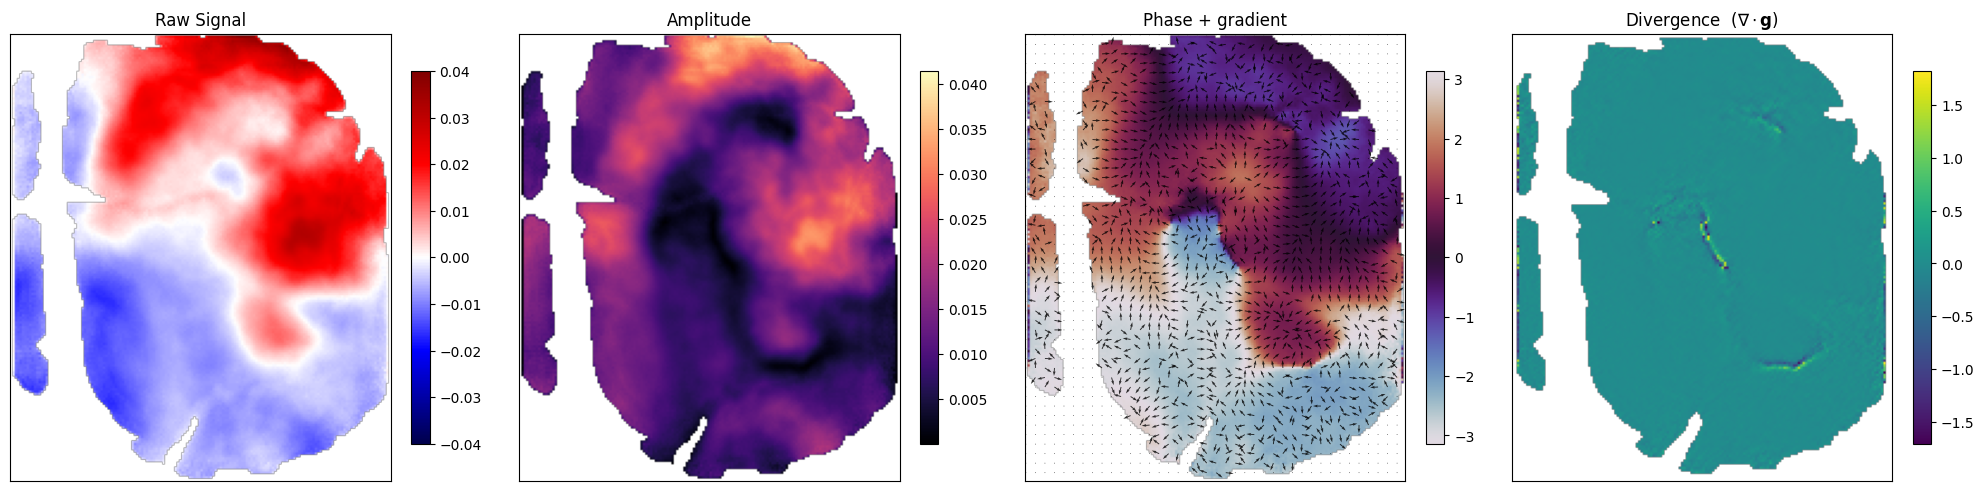

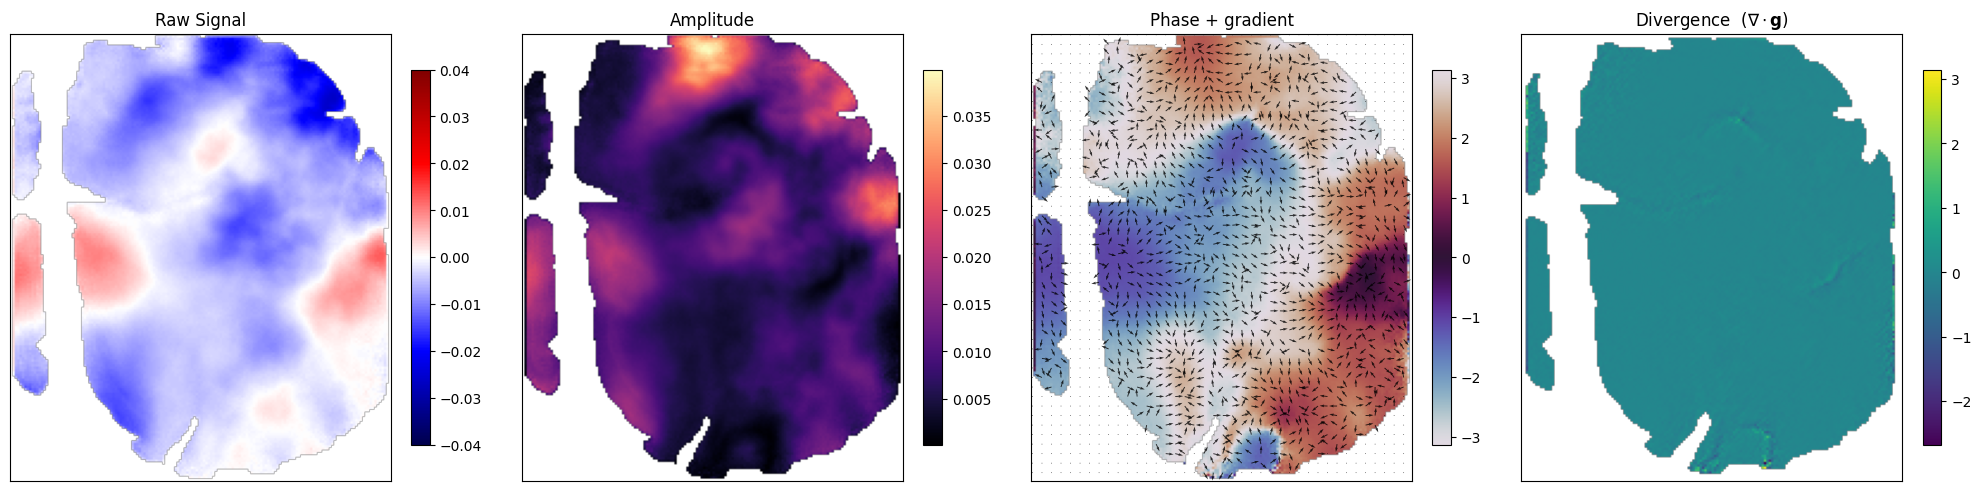

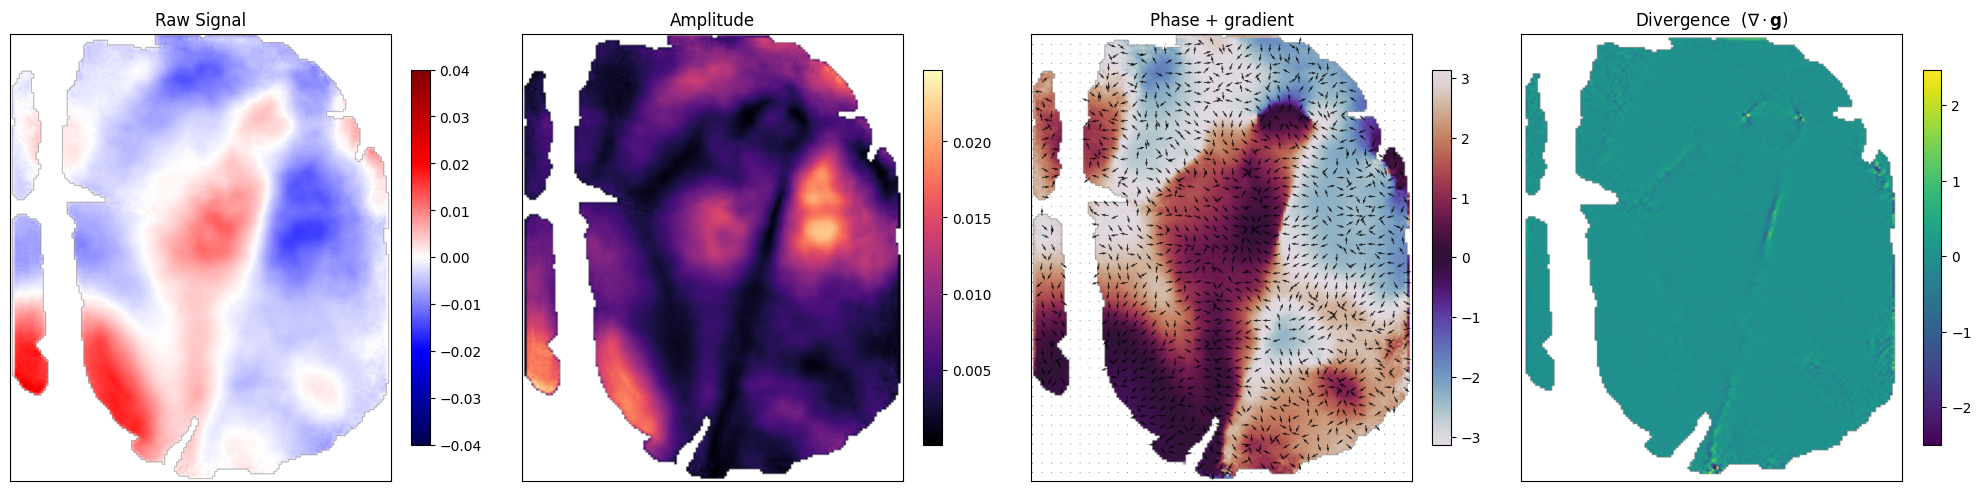

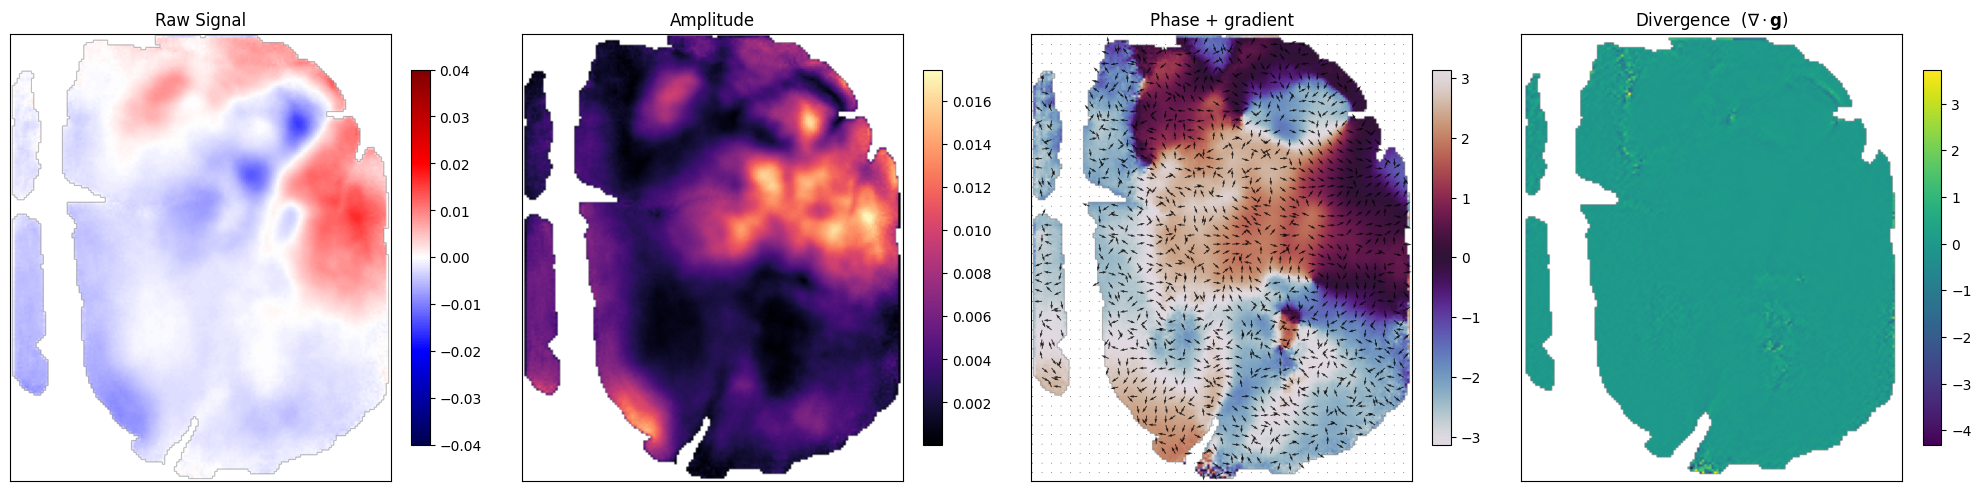

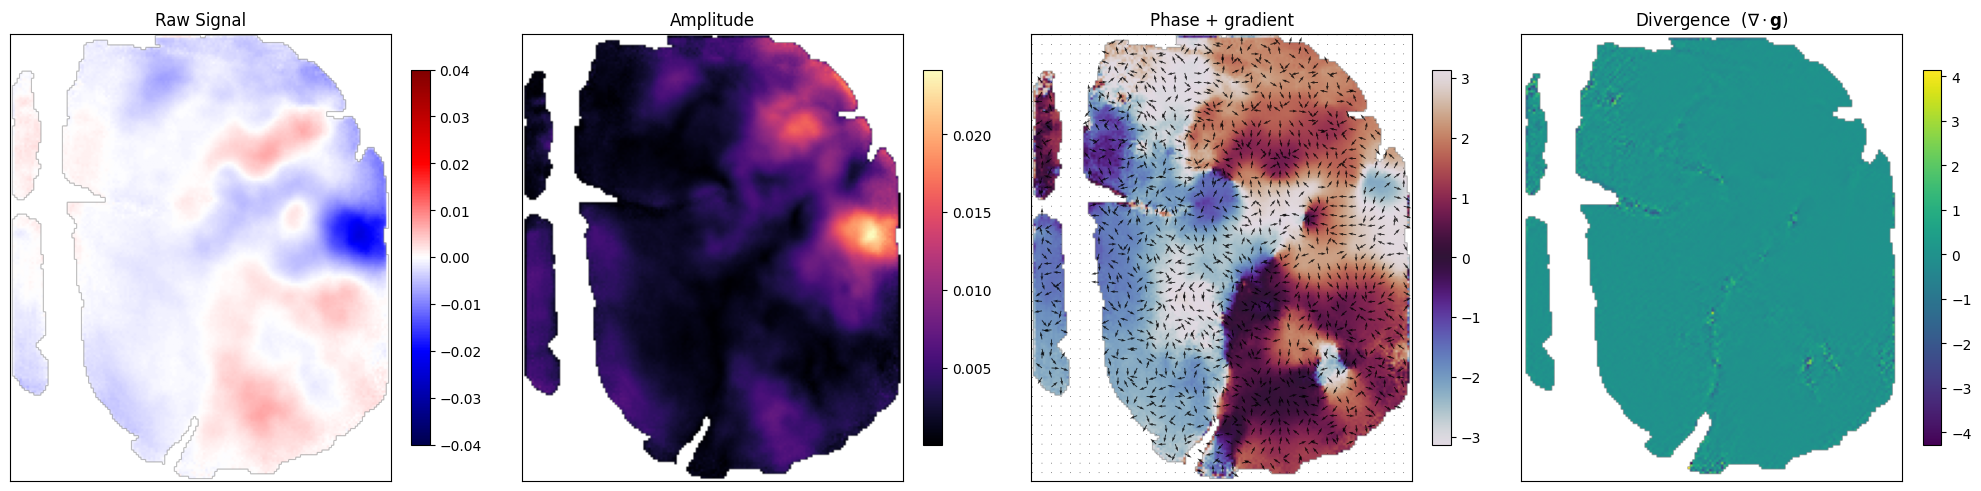

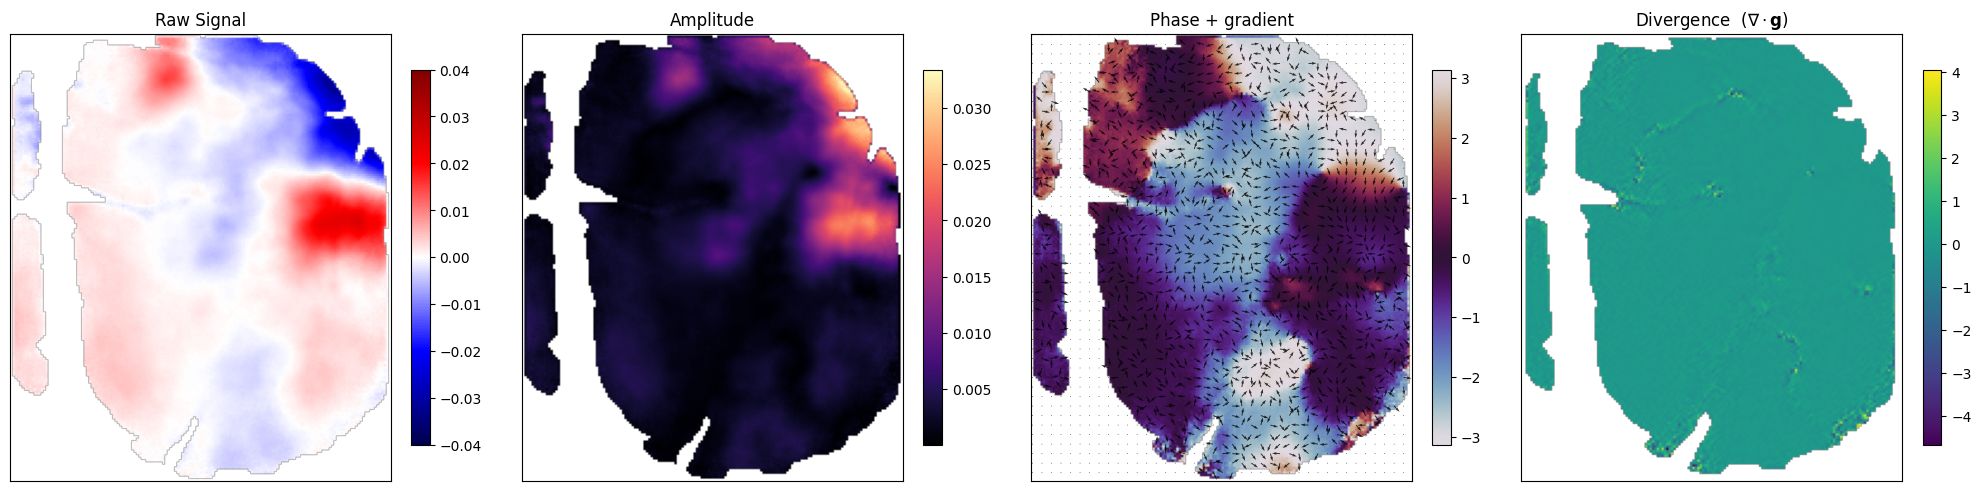

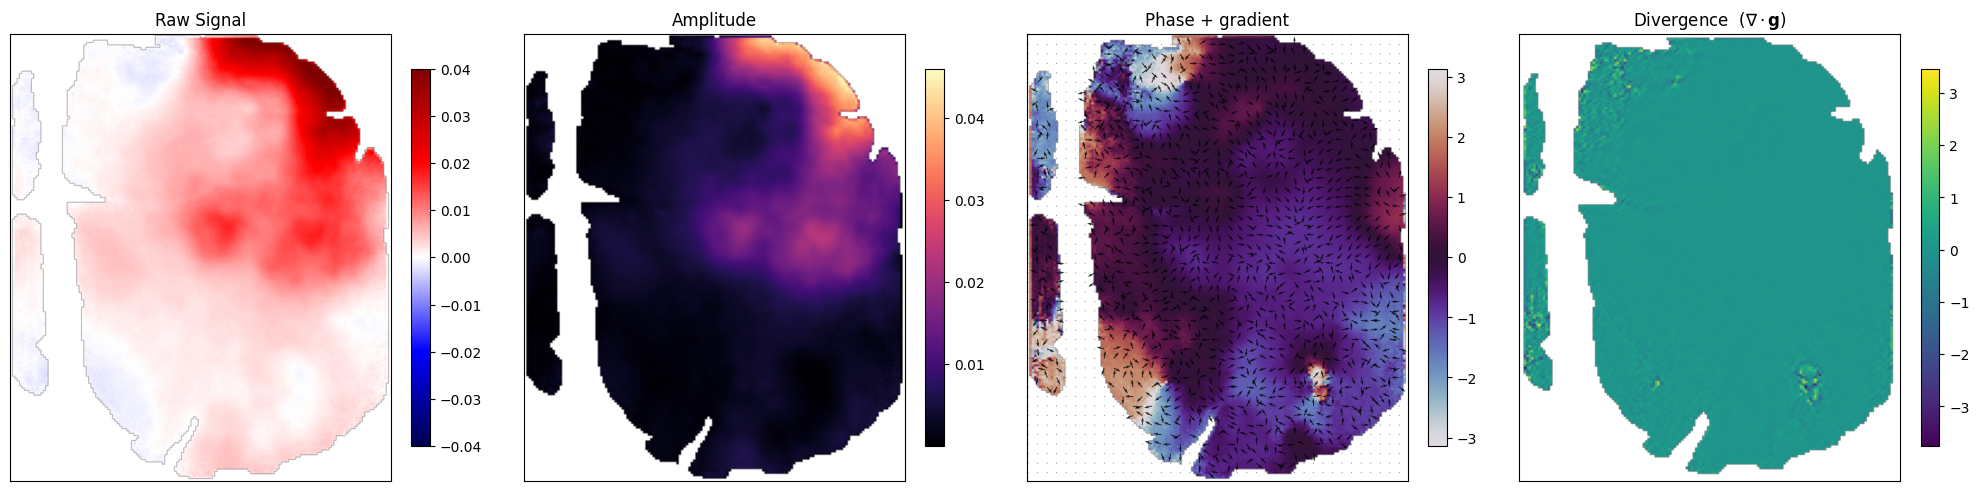

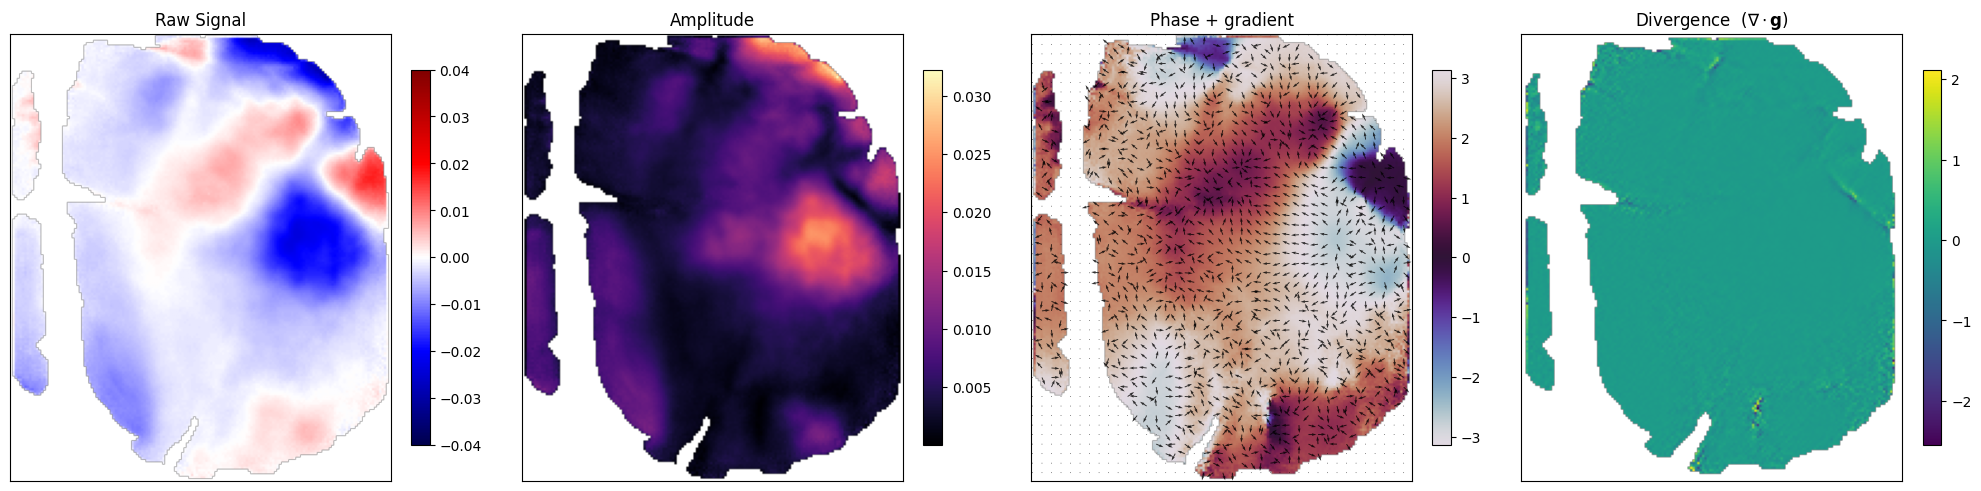

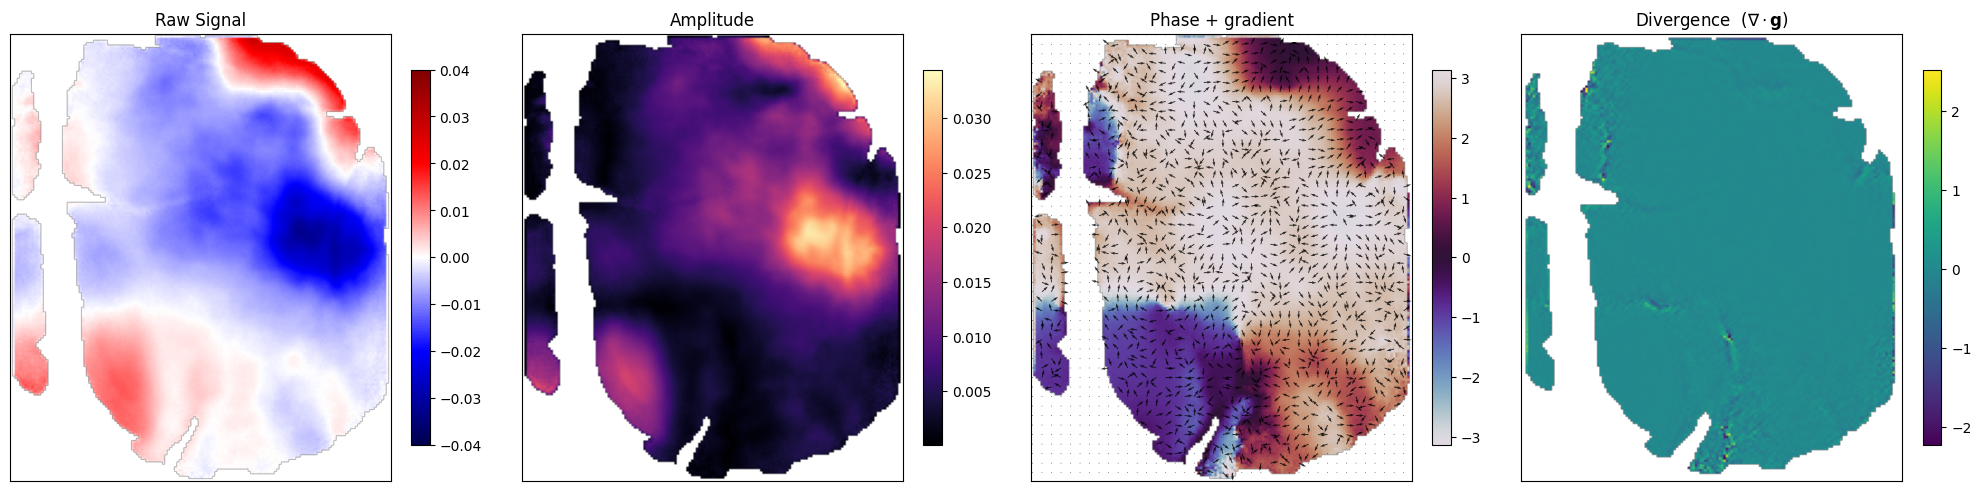

In [8]:
movie = np.load('wave_clip_masked.npy')
movie = movie.transpose(2, 1, 0)
movie = np.rot90(movie, k=1, axes=(0, 1))
Fs = 157

results = analyze_phase(movie, Fs, lo=2, hi=20, bandpass=False, sigma_px=0.0)
results_smoothed = analyze_phase(movie, Fs, lo=2, hi=20, bandpass=False, sigma_px=2.0)

for i in np.arange(10, len(movie), 20):
    plot_phase_results(movie, results, frame=i, plots=['raw_signal', 'amplitude', 'gradient_vectors', 'divergence'], smoothed=False)
    #plot_phase_results(movie, results_smoothed, frame=i, plots=['gradient_vectors', 'divergence', 'curl'], smoothed=False, title='Smoothed')
